In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %pip install pennylane
# %pip install PennyLane-qiskit

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np

tf.get_logger().setLevel('ERROR')

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

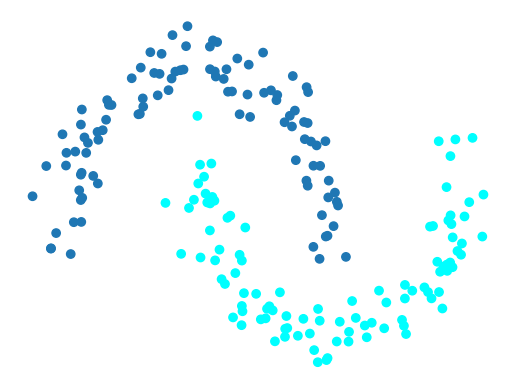

In [ ]:
X, y = make_moons(n_samples=200, noise=0.1)
y_hot = tf.keras.utils.to_categorical(y, num_classes=2)
c = ['#1f77b4' if y_ == 0 else '#00FFFF' for y_ in y]
plt.axis('off')
plt.scatter(X[:, 0], X[:, 1], c=c)
plt.show()

Cast the input data to float32

In [ ]:
X = X.astype('float32')
y_hot = y_hot.astype('float32')

Set up quantum circuit

In [ ]:
token = 'Enter your token'

In [ ]:
n_qubits = 2
# dev = qml.device("default.qubit", wires=n_qubits)
# dev = qml.device("qiskit.aer", wires=n_qubits)
dev = qml.device('qiskit.ibmq', wires=n_qubits, backend='ibmq_jakarta', ibmqx_token=token)

In [ ]:
@qml.qnode(dev)
def qnode(inputs, weights):
    weights = np.array(weights, dtype=np.float32)
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

n_layers = 3
weight_shapes = {"weights": (n_layers, n_qubits, 3)}

In [ ]:
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, output_dim=n_qubits)

Create the hybrid model

In [ ]:
model_h = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(2,)),
    qlayer,
    tf.keras.layers.Dense(2)  # Output layer
])

Compile the quantum model for regression using Stochastic Gradient Descent (SGD) optimizer and Fit the quantum model to data using SGD for optimization

In [ ]:
optimizer_h = tf.keras.optimizers.experimental.SGD(learning_rate=0.2)
model_h.compile(optimizer=optimizer_h, loss='mse', metrics=['accuracy'])

In [ ]:
h_history = model_h.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25)

Epoch 1/6


/usr/local/lib/python3.10/dist-packages/pennylane/math/utils.py:225: UserWarning: Contains tensors of types {'tensorflow', 'autograd'}; dispatch will prioritize TensorFlow, PyTorch, and  Jax over Autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pennylane_qiskit/ibmq.py:91: UserWarning: ibmqx_token is not a recognized runtime option and may be ignored by the backend.
  res = super().batch_execute(circuits, timeout=self.timeout_secs)


30/30 [==============================] - 757s 26s/step - loss: 0.3609 - accuracy: 0.5800 - val_loss: 0.1745 - val_accuracy: 0.7800
Epoch 2/6
30/30 [==============================] - 499s 17s/step - loss: 0.1637 - accuracy: 0.7867 - val_loss: 0.1449 - val_accuracy: 0.7400
Epoch 3/6
30/30 [==============================] - 485s 16s/step - loss: 0.1461 - accuracy: 0.8133 - val_loss: 0.1363 - val_accuracy: 0.7600
Epoch 4/6
30/30 [==============================] - 453s 15s/step - loss: 0.1378 - accuracy: 0.8133 - val_loss: 0.1270 - val_accuracy: 0.8000
Epoch 5/6
30/30 [==============================] - 480s 16s/step - loss: 0.1335 - accuracy: 0.7933 - val_loss: 0.1304 - val_accuracy: 0.8000
Epoch 6/6
30/30 [==============================] - 486s 16s/step - loss: 0.1276 - accuracy: 0.8333 - val_loss: 0.1780 - val_accuracy: 0.7800


In [ ]:
print(model_h.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2)                 18        
                                                                 
 dense (Dense)               (None, 2)                 6         
                                                                 
Total params: 24
Trainable params: 24
Non-trainable params: 0
_________________________________________________________________
None


Validations of the quantum model

In [ ]:
X_val, y_val = make_moons(n_samples=100, noise=0.1)
y_hot_pred = model_h.predict(X_val)
y_pred = tf.argmax(y_hot_pred, axis=1)

4/4 [==============================] - 66s 15s/step


In [ ]:
acc = tf.keras.metrics.Accuracy()
acc(y_pred, y_val)

<tf.Tensor: shape=(), dtype=float32, numpy=0.77>

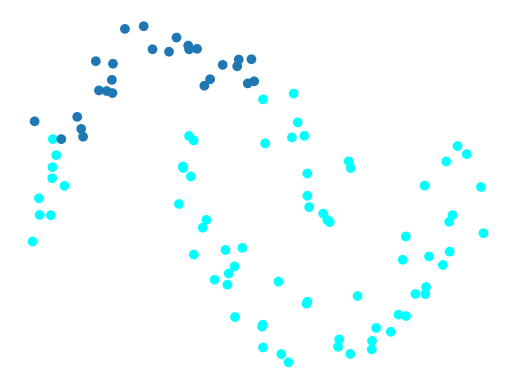

In [ ]:
c = ['#1f77b4' if y_ == 0 else '#00FFFF' for y_ in y_pred]
plt.axis('off')
plt.scatter(X_val[:, 0], X_val[:, 1], c=c)
plt.show()

Create classical model

In [ ]:
clayer_1 = tf.keras.layers.Dense(2)
clayer_2 = tf.keras.layers.Dense(2, activation='softmax')
model_c = tf.keras.models.Sequential([clayer_1, clayer_2])

optimizer_c = tf.keras.optimizers.experimental.SGD(learning_rate=0.2)
model_c.compile(optimizer=optimizer_c, loss='mae', metrics=['accuracy'])

Fit the classical model

In [ ]:
c_history = model_c.fit(X, y_hot, epochs=6, batch_size=5, validation_split=0.25)

Epoch 1/6
30/30 [==============================] - 1s 10ms/step - loss: 0.5401 - accuracy: 0.4267 - val_loss: 0.2498 - val_accuracy: 0.7800
Epoch 2/6
30/30 [==============================] - 0s 4ms/step - loss: 0.2308 - accuracy: 0.8200 - val_loss: 0.1938 - val_accuracy: 0.8200
Epoch 3/6
30/30 [==============================] - 0s 4ms/step - loss: 0.1887 - accuracy: 0.8200 - val_loss: 0.1800 - val_accuracy: 0.8200
Epoch 4/6
30/30 [==============================] - 0s 4ms/step - loss: 0.1722 - accuracy: 0.8400 - val_loss: 0.1727 - val_accuracy: 0.8200
Epoch 5/6
30/30 [==============================] - 0s 6ms/step - loss: 0.1607 - accuracy: 0.8467 - val_loss: 0.1684 - val_accuracy: 0.8400
Epoch 6/6
30/30 [==============================] - 0s 7ms/step - loss: 0.1526 - accuracy: 0.8600 - val_loss: 0.1671 - val_accuracy: 0.8200


In [ ]:
print(model_c.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (5, 2)                    6         
                                                                 
 dense_4 (Dense)             (5, 2)                    6         
                                                                 
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None


Validation

In [ ]:
X_val, y_val = make_moons(n_samples=100, noise=0.1)
y_hot_pred = model_c.predict(X_val)
y_pred = tf.argmax(y_hot_pred, axis=1)

4/4 [==============================] - 0s 3ms/step


In [ ]:
acc = tf.keras.metrics.Accuracy()
acc(y_pred, y_val)

<tf.Tensor: shape=(), dtype=float32, numpy=0.87>

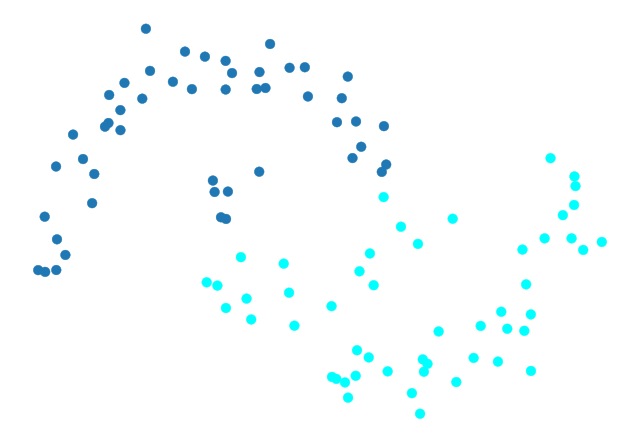

In [ ]:
c = ['#1f77b4' if y_ == 0 else '#00FFFF' for y_ in y_pred]
plt.axis('off')
plt.scatter(X_val[:, 0], X_val[:, 1], c=c)
plt.show()

Visualization

<ipython-input-29-768d29f1b0b5>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


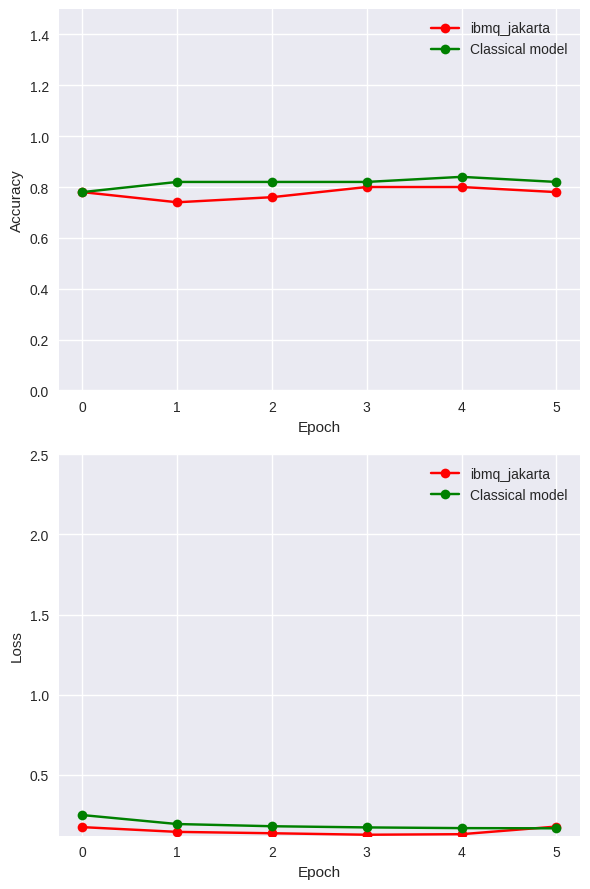

In [ ]:
plt.style.use("seaborn")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

ax1.plot(h_history.history["val_accuracy"], "-or", label="ibmq_jakarta")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Classical model")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1.5])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(h_history.history["val_loss"], "-or", label="ibmq_jakarta")
ax2.plot(c_history.history["val_loss"], "-og", label="Classical model")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()